## Mapping HiC data

First, let's create a reference from just human chromosome 1 (build hg19). So we neet to get that fasta file:

```bash
wget https://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/chr1.fa.gz
```

Then, we'll need to create our index.

```bash
mkdir index
bowtie2-build --threads 7 chr1.fa.gz index/hg19chr1
```

Now let's fetch our data.

```bash
wget https://bx.bio.jhu.edu/data/msauria/cmdb-lab/hic_example_reads.tgz
tar xzf hic_example_reads.tgz
```

We should have two fastq files, one for each side of a paired end sequencing run. Now, let's map them.

```bash
bowtie2 -p 7 -x index/hg19chr1 -1 hic_example_1.fastq -2 hic_example_2.fastq > mapped.sam
```

And viola, we have mapped reads. No we need to see what they can tell us.

## Parsing HiC data

Let's load the reads into python and bin them into genomic intervals. Because we're using 2 dimensions (one for the first read and another for the second read), we will use a 2D matrix to keep track of our data. And I can tell you that our coordinate range for these reads is 50Mb-60Mb and we will be using 10Kb bins.

In [4]:
import numpy

counts = numpy.zeros((1000, 1000), int)
for line in open('mapped.sam'):
    if line.startswith('@'):
        continue
    fields = line.split()
    if fields[0].endswith("1"):
        x = (int(fields[3]) - 50000000) // 10000
    else:
        y = (int(fields[3]) - 50000000) // 10000
        if x >= 0 and x < 1000 and y >= 0 and y < 1000: 
            counts[x, y] += 1
counts += counts.T

## Plotting HiC data

Next, let's plot our data to see what it looks like.

/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


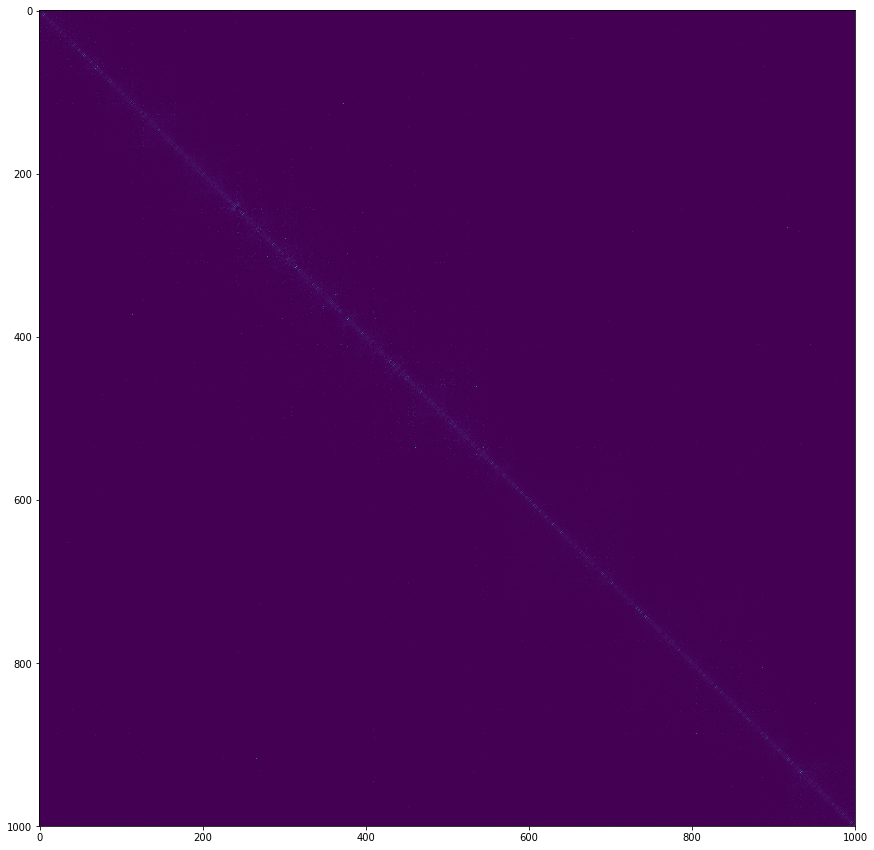

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(counts)
fig.show()

/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


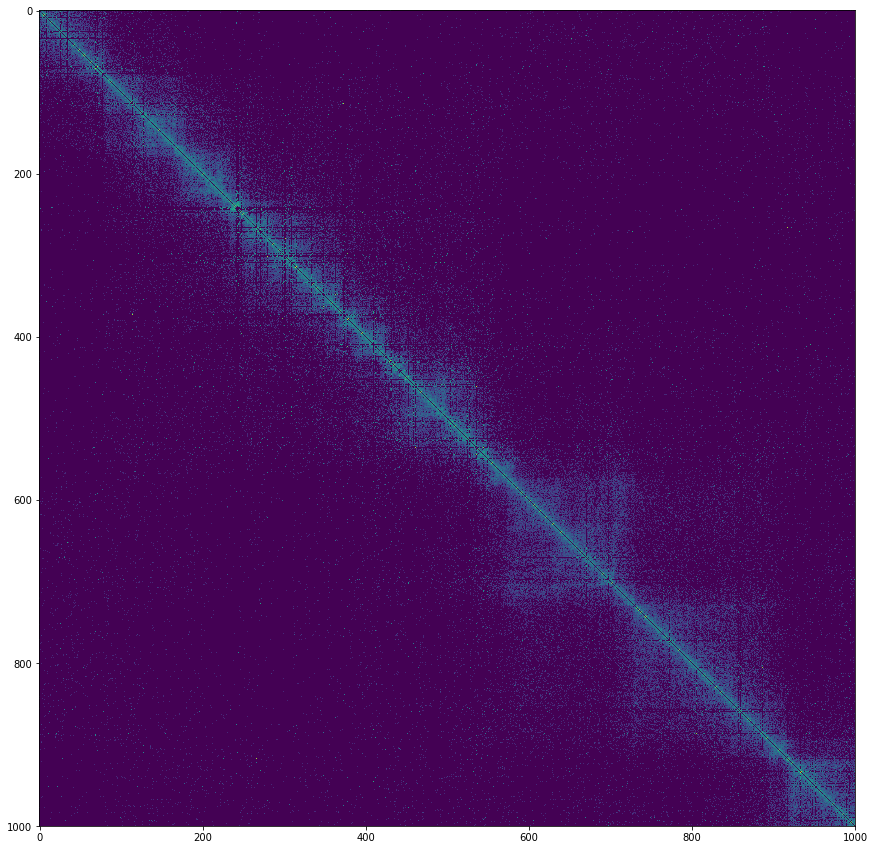

In [57]:
# What if we transform the data?
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(numpy.log10(1 + counts))
fig.show()


/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


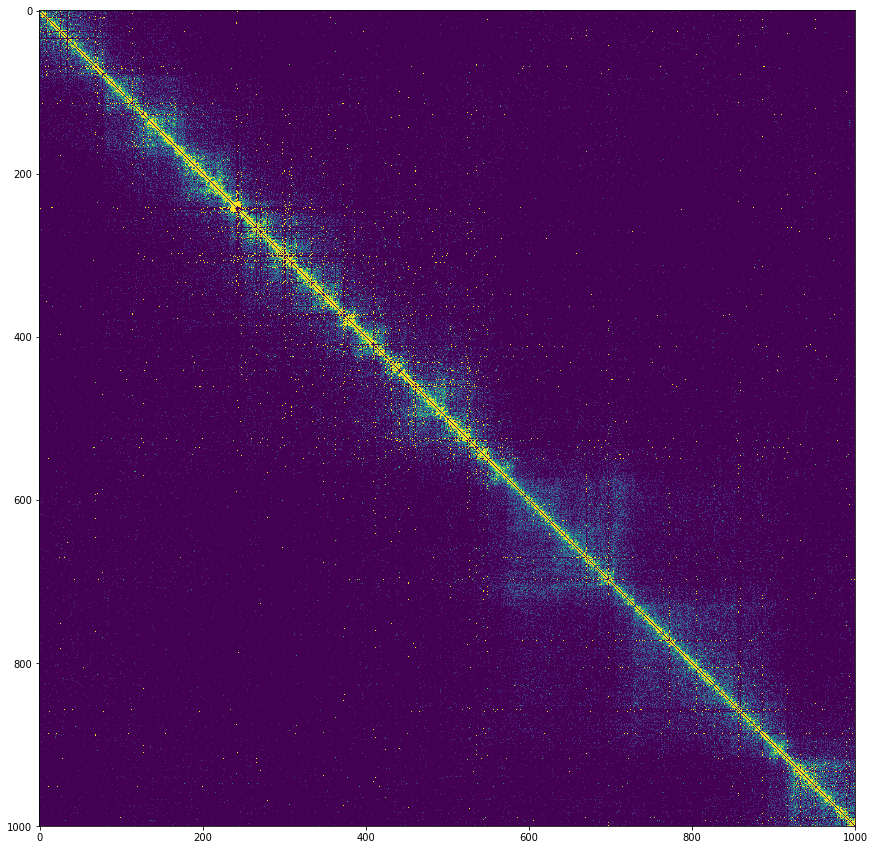

In [58]:
# Alternatively, we could just set a lower maximum value
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(counts, vmax=10)
fig.show()

/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


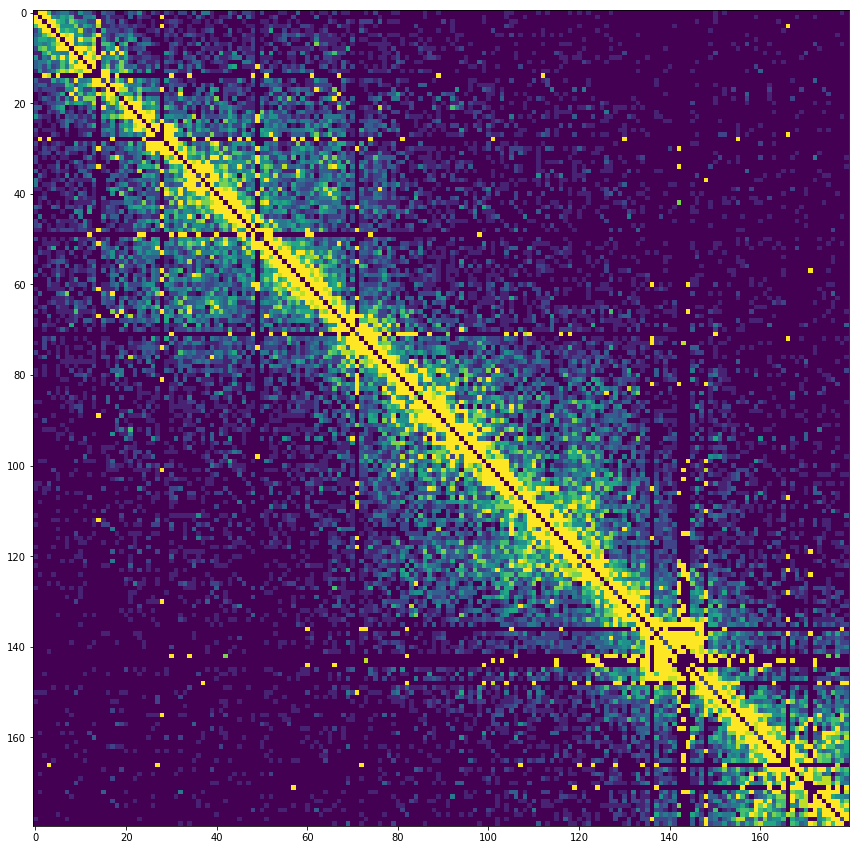

In [59]:
# Let's zoom in on bins 100-250
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(counts[100:280, 100:280], vmax=10)
fig.show()


## Adding gene expression data

Now let's see how this relates to the genes in the area.

In [60]:
coords = []
expr = []
for line in open('hic_example_FPKM.bed'):
    line = line.rstrip().split()
    coords.append((float(line[1]), float(line[2])))
    expr.append(float(line[4]))
coords = numpy.array(coords)
coords -= 50000000
coords /= 10000000
print(numpy.amin(coords), numpy.amax(coords))
coords *= 1000
expr = numpy.array(expr)
expr = numpy.log10(1 + expr)
expr /= numpy.amax(expr)


0.045999 1.0233347


/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


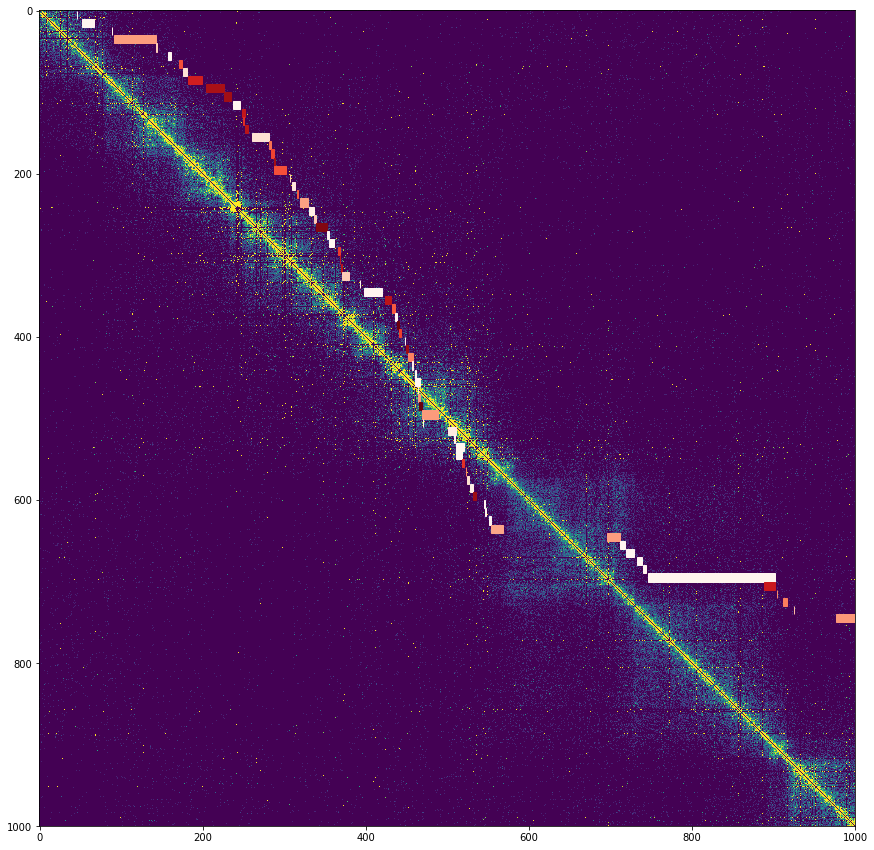

In [61]:
import matplotlib.cm as cm
import matplotlib.patches as patches

cmap = cm.get_cmap('Reds', 256)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(counts, vmax=10)
for i in range(coords.shape[0]):
    rect = patches.Rectangle((coords[i, 0], i*10), coords[i, 1] - coords[i, 0], 10, edgecolor=cmap(expr[i]), facecolor=cmap(expr[i]))
    ax.add_patch(rect)
fig.show()


/Users/msauria/miniconda2/envs/py3/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


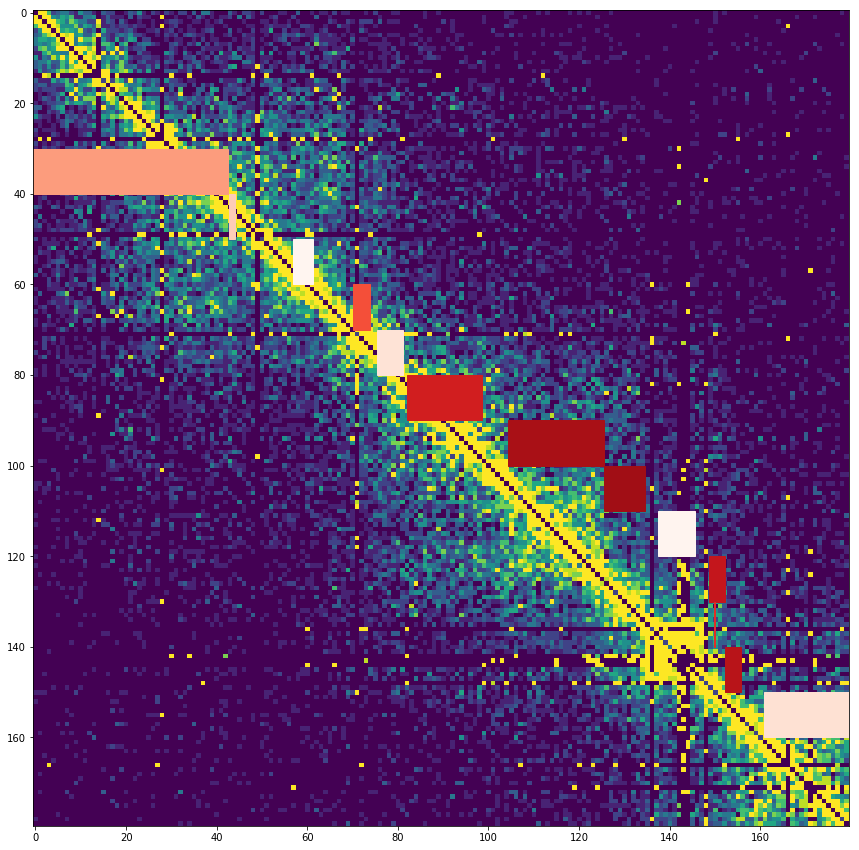

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(counts[100:280, 100:280], vmax=10)
for i in range(coords.shape[0]):
    rect = patches.Rectangle((coords[i, 0] - 100, i*10), coords[i, 1] - coords[i, 0], 10, edgecolor=cmap(expr[i]), facecolor=cmap(expr[i]))
    ax.add_patch(rect)
fig.show()
